<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_basic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we perform a basic analysis with `SingleCellExperiment`. It takes a while to install the dependencies, as most of the time is taken by the compiler (wouldn't be this bad on Windows or Mac since there're binaries). Everything is built from source here.

In [0]:
start_time <- Sys.time()

In [2]:
system.time({
install.packages(c("BiocManager", "patchwork", "Rtsne", "uwot"), Ncpus = 2)
BiocManager::install(c("DropletUtils", "scater", "scran"), Ncpus = 2)
})

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppEigen’, ‘sitmo’, ‘FNN’, ‘RSpectra’, ‘RcppAnnoy’, ‘RcppParallel’, ‘irlba’, ‘RcppProgress’, ‘dqrng’


Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'DropletUtils', 'scater', 'scran'

also installing the dependencies ‘formatR’, ‘zlibbioc’, ‘bitops’, ‘lambda.r’, ‘futile.options’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘futile.logger’, ‘snow’, ‘locfit’, ‘IRanges’, ‘R.oo’, ‘R.methodsS3’, ‘GenomicRanges’, ‘Biobase’, ‘GenomeInfoDb’, ‘beeswarm’, ‘vipor’, ‘matrixStats’, ‘gridExtra’, ‘RcppHNSW’, ‘rsvd’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘BiocParallel’, ‘edgeR’, ‘rhdf5’, ‘HDF5Array’, ‘R.utils’, ‘beachmat’, ‘Rhdf5lib’, ‘BiocGenerics’, ‘SummarizedExperiment’, ‘ggbeeswarm’, ‘DelayedArray’, ‘DelayedMatrixStats’, ‘viridis’, ‘BiocNeighbors’, ‘BiocSingular’, ‘limma’, ‘igraph’, ‘statmod’


Old packages: 'curl', 'dplyr', 

    user   system  elapsed 
2200.762  173.577 1373.402 

In [0]:
system("pip3 install kb-python")

In [0]:
download.file("https://caltech.box.com/shared/static/w9ww8et5o029s2e3usjzpbq8lpot29rh.gz", 
destfile = "SRR8599150_S1_L001_R1_001.fastq.gz")
download.file("https://caltech.box.com/shared/static/ql00zyvqnpy7bf8ogdoe9zfy907guzy9.gz",
destfile = "SRR8599150_S1_L001_R2_001.fastq.gz")

In [0]:
system("kb ref -d mouse -i index.idx -g t2g.txt")

In [0]:
system("kb count -i index.idx -g t2g.txt -x 10xv2 -t2 -o . SRR8599150_S1_L001_R1_001.fastq.gz SRR8599150_S1_L001_R2_001.fastq.gz")

In [7]:
library(DropletUtils)
library(Matrix)
library(scater)
library(scran)
library(tidyverse)
library(patchwork)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

In [0]:
# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}

In [9]:
list.files(".", recursive = TRUE)

[1] "10xv2_whitelist.txt"                         
 [2] "counts_unfiltered/cells_x_genes.barcodes.txt"
 [3] "counts_unfiltered/cells_x_genes.genes.txt"   
 [4] "counts_unfiltered/cells_x_genes.mtx"         
 [5] "index.idx"                                   
 [6] "inspect.json"                                
 [7] "matrix.ec"                                   
 [8] "output.bus"                                  
 [9] "output.unfiltered.bus"                       
[10] "run_info.json"                               
[11] "sample_data/anscombe.json"                   
[12] "sample_data/california_housing_test.csv"     
[13] "sample_data/california_housing_train.csv"    
[14] "sample_data/mnist_test.csv"                  
[15] "sample_data/mnist_train_small.csv"           
[16] "sample_data/README.md"                       
[17] "SRR8599150_S1_L001_R1_001.fastq.gz"          
[18] "SRR8599150_S1_L001_R2_001.fastq.gz"          
[19] "t2g.txt"                                     
[20] "transcripts.txt"

In [0]:
res_mat <- read_count_output("counts_unfiltered", name = "cells_x_genes")

# Remove empty droplets

In [11]:

dim(res_mat)

[1] 55421 96775

In [12]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    1.00   25.74    3.00 2753.00 

In [0]:
bc_rank <- barcodeRanks(res_mat, lower = 10)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(rank, total)) +
    geom_line() +
    geom_hline(aes(yintercept = inflection), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = rank_cutoff), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(x = "Rank", y = "Total UMIs")
  return(p)
}

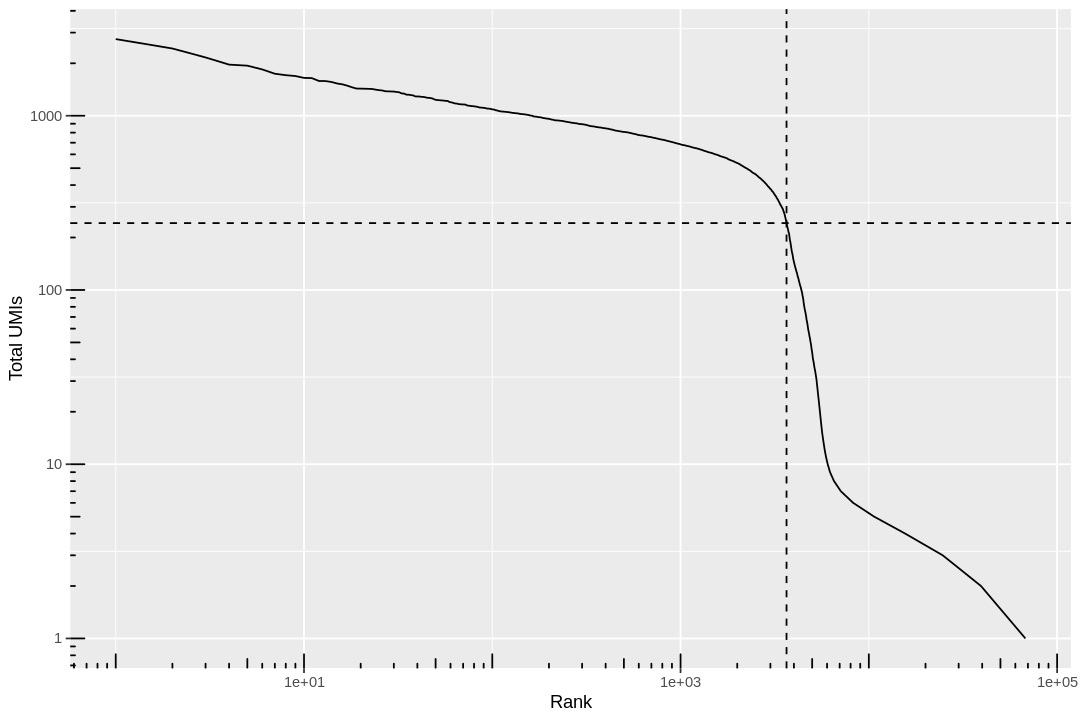

In [15]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

In [16]:
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 21574  3655

# QC

Percentage of transcripts from mitochondrially encoded genes

In [17]:
tr2g <- read_tsv("t2g.txt", col_names = c("transcript", "gene", "gene_symbol")) %>%
  select(-transcript) %>%
  distinct()

Parsed with column specification:
cols(
  transcript = col_character(),
  gene = col_character(),
  gene_symbol = col_character()
)



In [0]:
mt_inds <- which(rownames(res_mat) %in% tr2g$gene[str_detect(tr2g$gene_symbol, "^mt-")])

In [19]:
sce <- SingleCellExperiment(assays = list(counts = res_mat))
sce <- logNormCounts(sce)
df <- perCellQCMetrics(sce, subsets = list(Mito = mt_inds))
colData(sce) <- cbind(colData(sce), df)
colData(sce)

DataFrame with 3655 rows and 10 columns
                       sum  detected   percent_top_50  percent_top_100
                 <numeric> <integer>        <numeric>        <numeric>
AAACCTGAGACGCAAC      1093       626 38.7008234217749 49.4053064958829
AAACCTGCAGACGCCT       764       493 37.9581151832461 48.5602094240838
AAACCTGGTAGAGTGC       261       189 46.7432950191571 65.9003831417624
AAACCTGTCGATGAGG       676       413  43.491124260355  53.698224852071
AAACGGGAGATCACGG       512       318         46.09375        57.421875
...                    ...       ...              ...              ...
TTTGTCAAGCCACGCT       548       352 42.5182481751825  54.014598540146
TTTGTCAAGCTAGTTC       362       258 42.5414364640884  56.353591160221
TTTGTCACAGCTGTTA       737       483 36.9063772048847 48.0325644504749
TTTGTCAGTATAGGGC       686       328 56.4139941690962 66.7638483965015
TTTGTCATCGCGTAGC       628       356 49.5222929936306 59.2356687898089
                  percent_top_200  pe

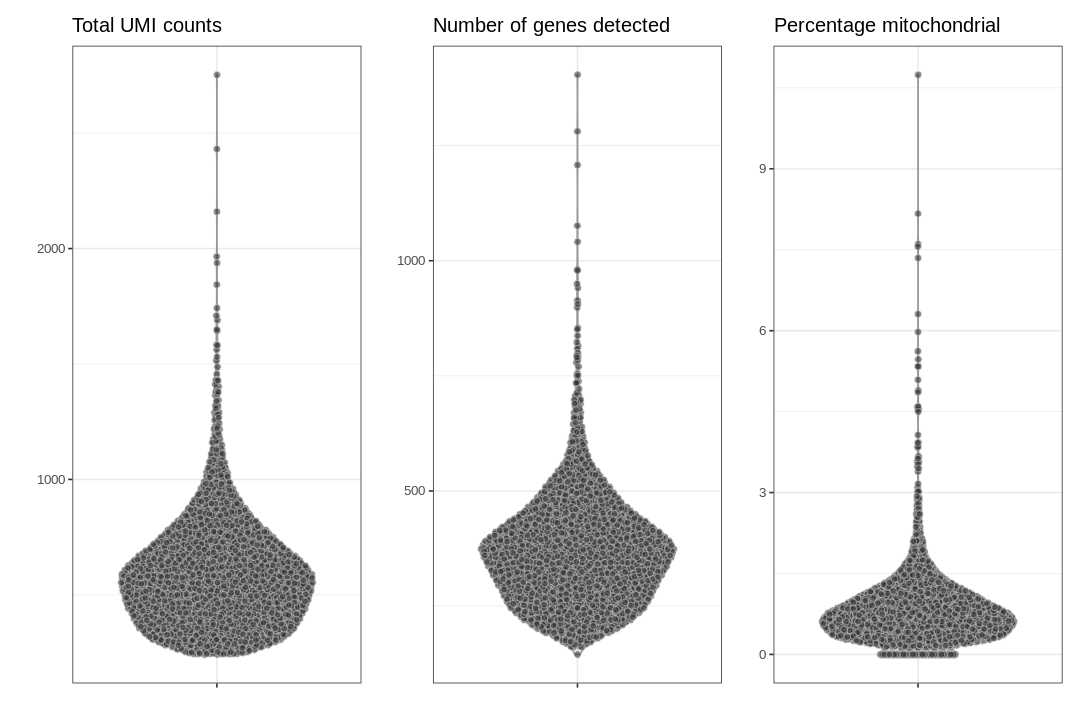

In [20]:
p1 <- plotColData(sce, "sum") + labs(y = "", title = "Total UMI counts")
p2 <- plotColData(sce, "detected") + labs(y = "", title = "Number of genes detected")
p3 <- plotColData(sce, "subsets_Mito_percent") + labs(y = "", title = "Percentage mitochondrial")
p1 + p2 + p3

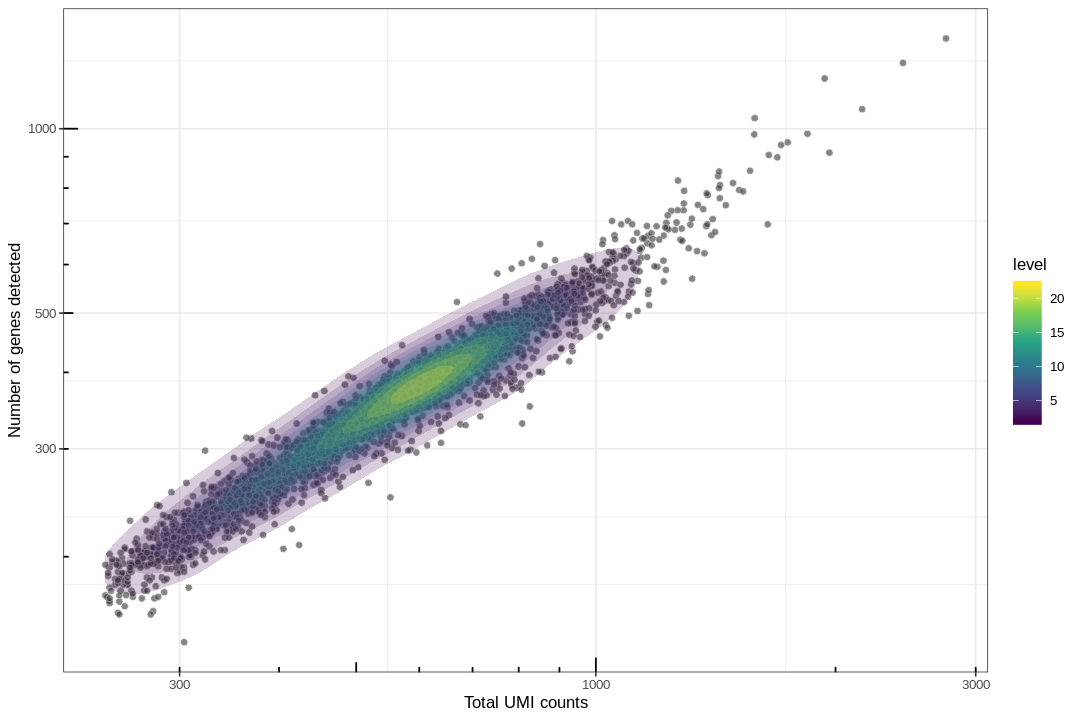

In [21]:
plotColData(sce, x = "sum", y = "detected") +
  stat_density_2d(aes(fill = stat(level)), geom = "polygon", alpha = 0.2) +
  scale_fill_viridis_c() +
  scale_x_log10() +
  scale_y_log10() +
  annotation_logticks() +
  labs(x = "Total UMI counts", y = "Number of genes detected")

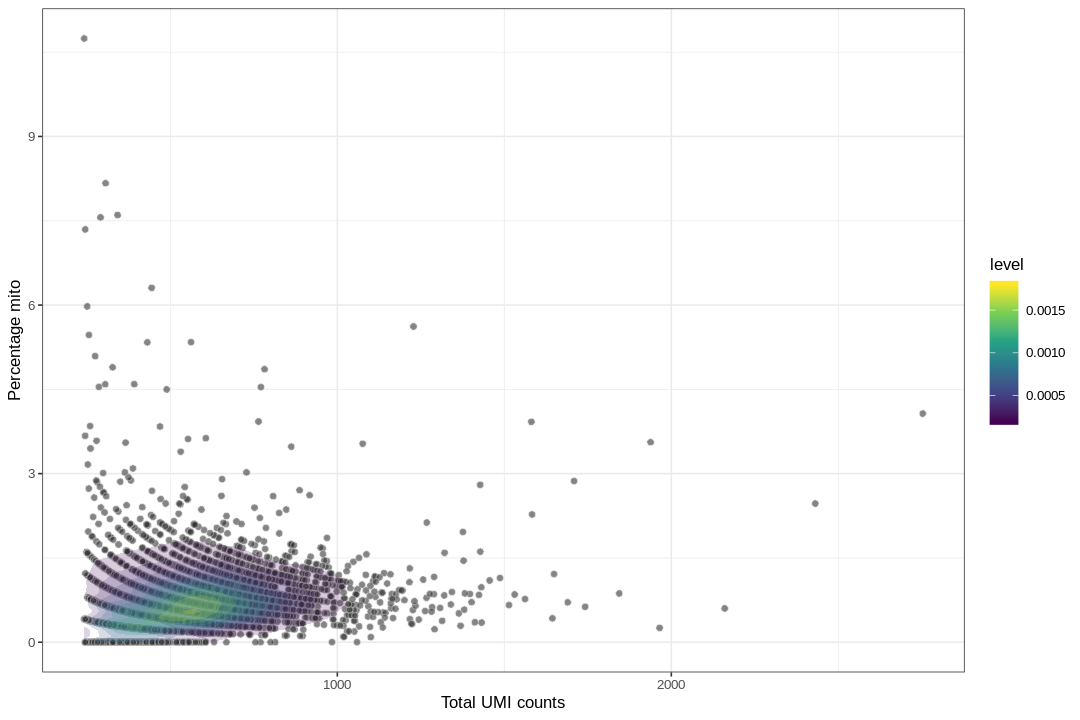

In [22]:
plotColData(sce, x = "sum", y = "subsets_Mito_percent") +
  stat_density_2d(aes(fill = stat(level)), geom = "polygon", alpha = 0.2) +
  scale_fill_viridis_c() +
  labs(x = "Total UMI counts", y = "Percentage mito")

In [0]:
sce <- sce[, sce$subsets_Mito_percent < 3]

# Dimension reduction
## Get highly variable genes

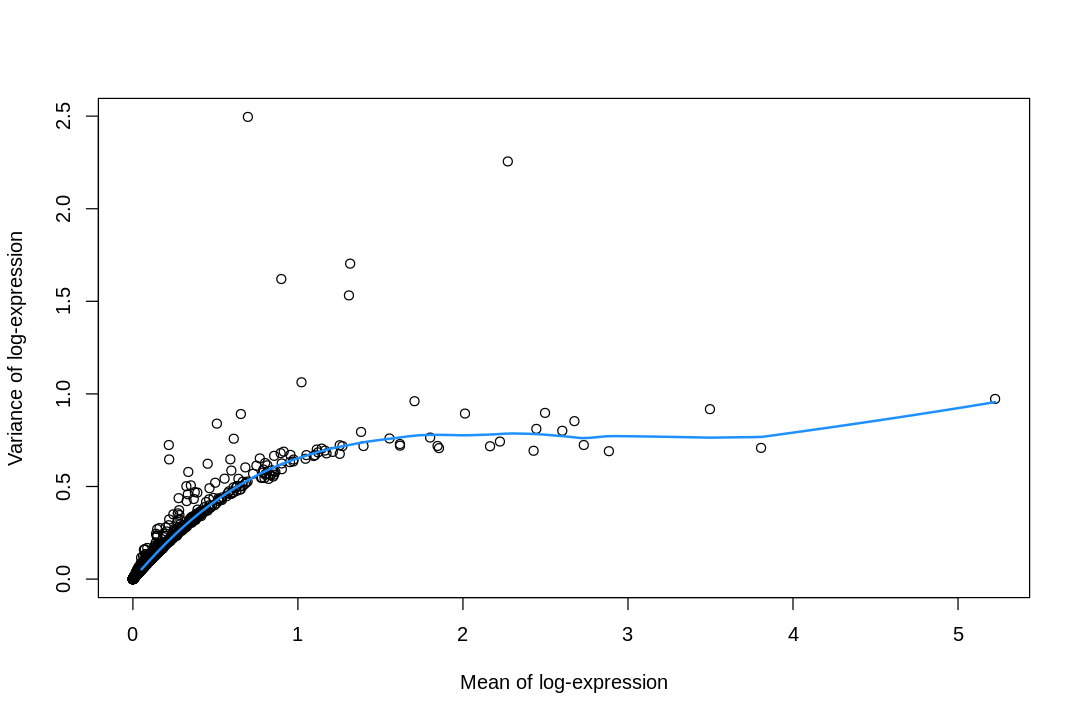

In [24]:
dec_sce <- modelGeneVar(sce)
fit_pbmc <- metadata(dec_sce)
# Adapted from https://osca.bioconductor.org/feature-selection.html#feature-selection
plot(fit_pbmc$mean, fit_pbmc$var, xlab="Mean of log-expression",
    ylab="Variance of log-expression")
curve(fit_pbmc$trend(x), col="dodgerblue", add=TRUE, lwd=2)

In [0]:
hvgs <- getTopHVGs(dec_sce, n = 3000)
sce <- runPCA(sce, subset_row = hvgs)

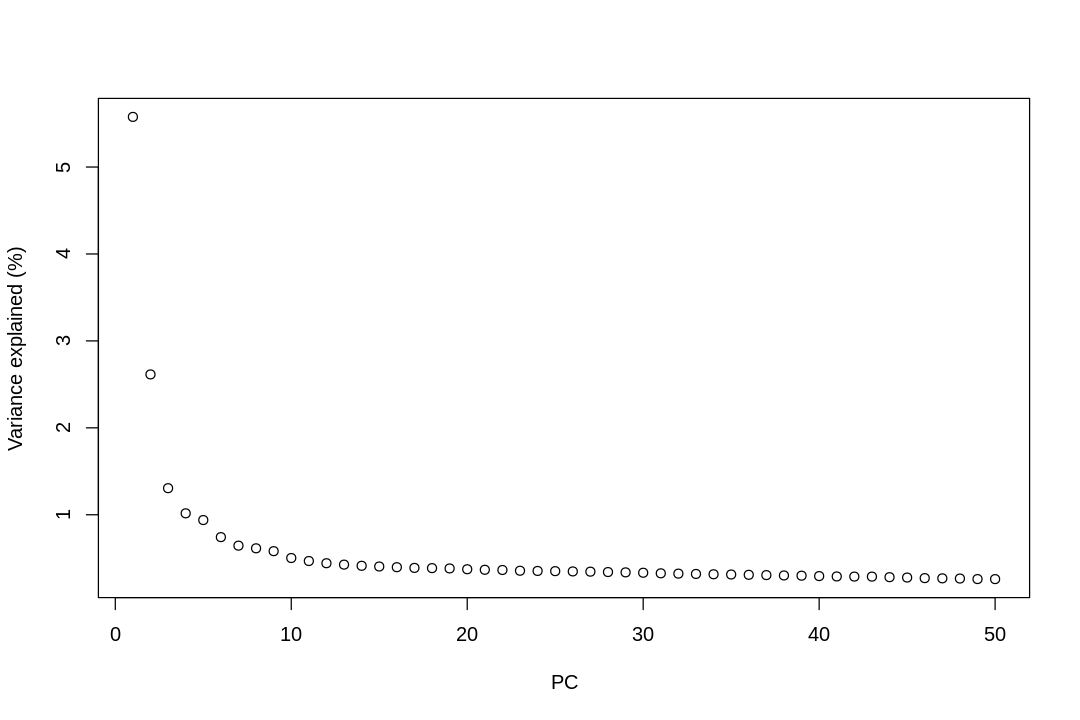

In [26]:
# Percentage of variance explained is tucked away in the attributes.
percent.var <- attr(reducedDim(sce), "percentVar")
plot(percent.var, xlab="PC", ylab="Variance explained (%)")

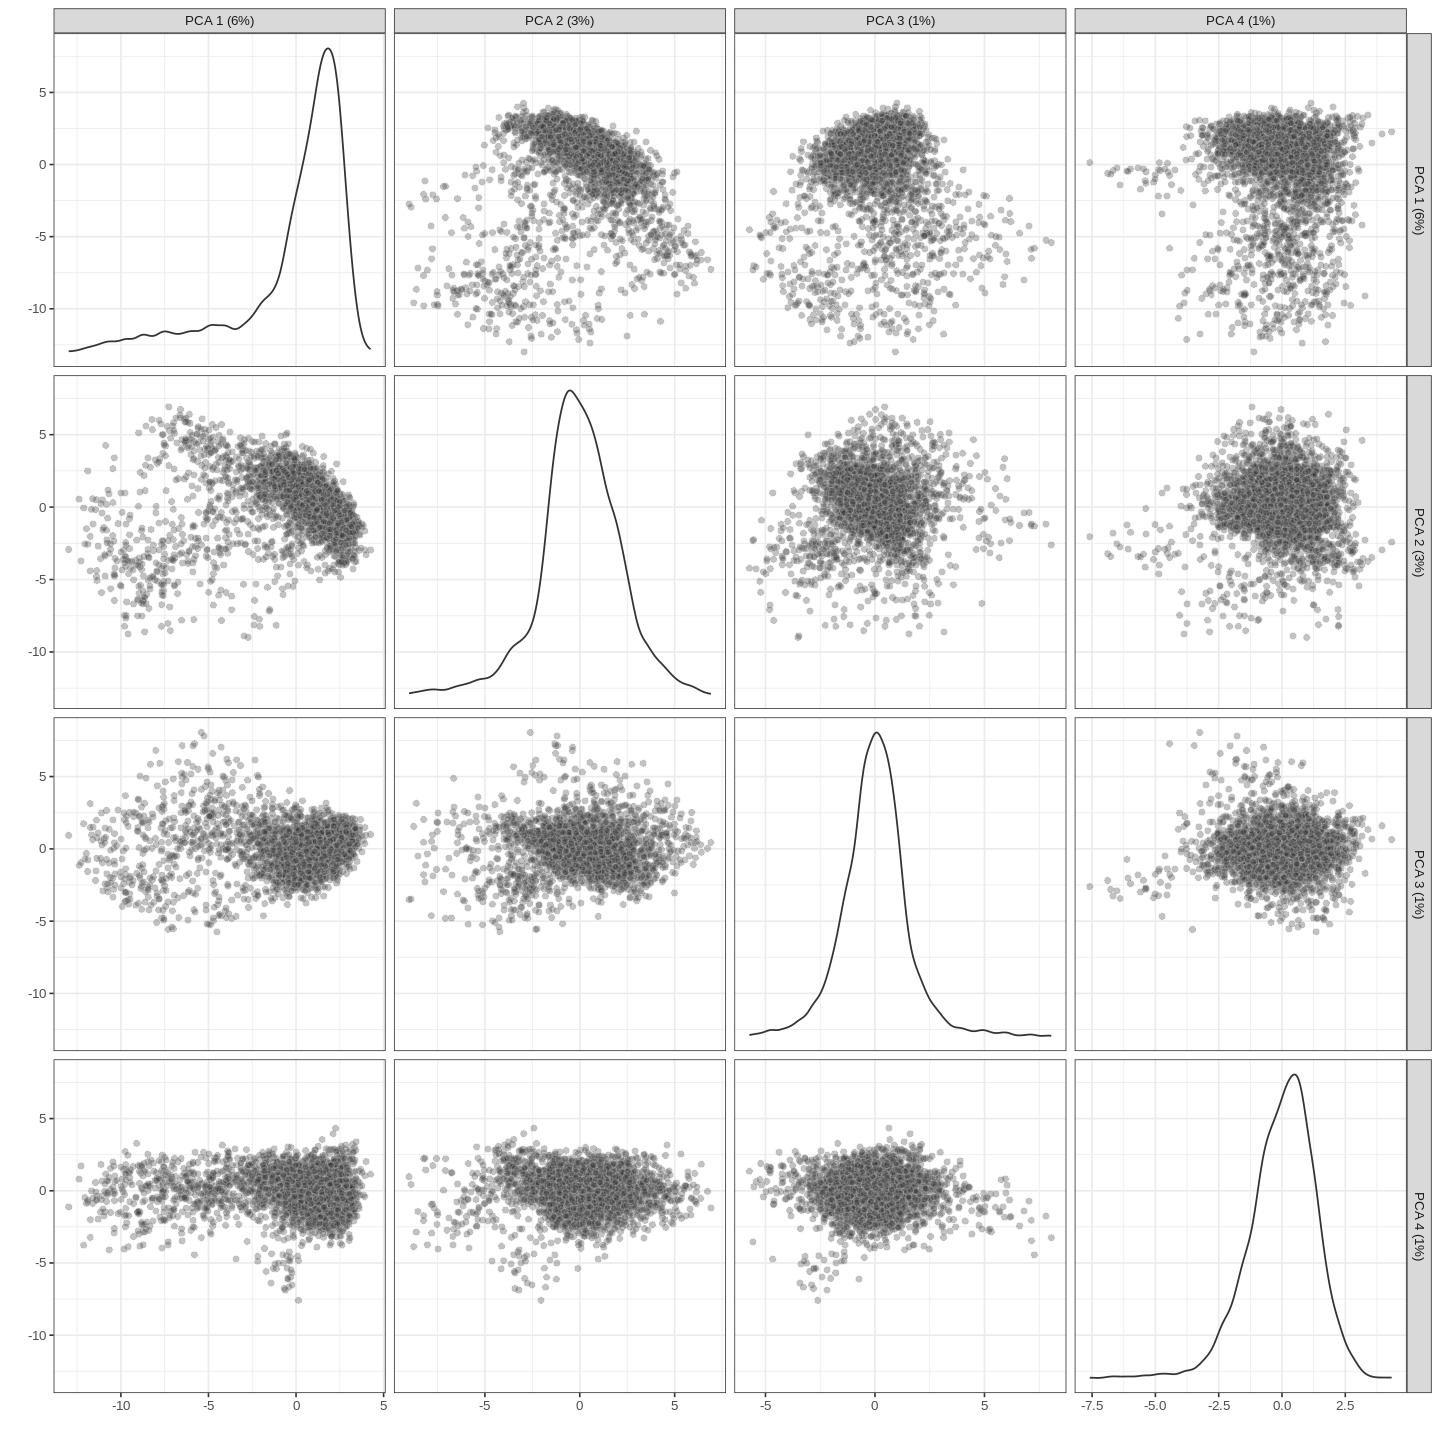

In [27]:
options(repr.plot.width=12, repr.plot.height=12)
plotPCA(sce, ncomponents = 4, point_alpha = 0.3)

In [0]:
g <- buildSNNGraph(sce, k = 15, use.dimred = "PCA")
sce$cluster <- igraph::cluster_louvain(g)$membership %>% factor()

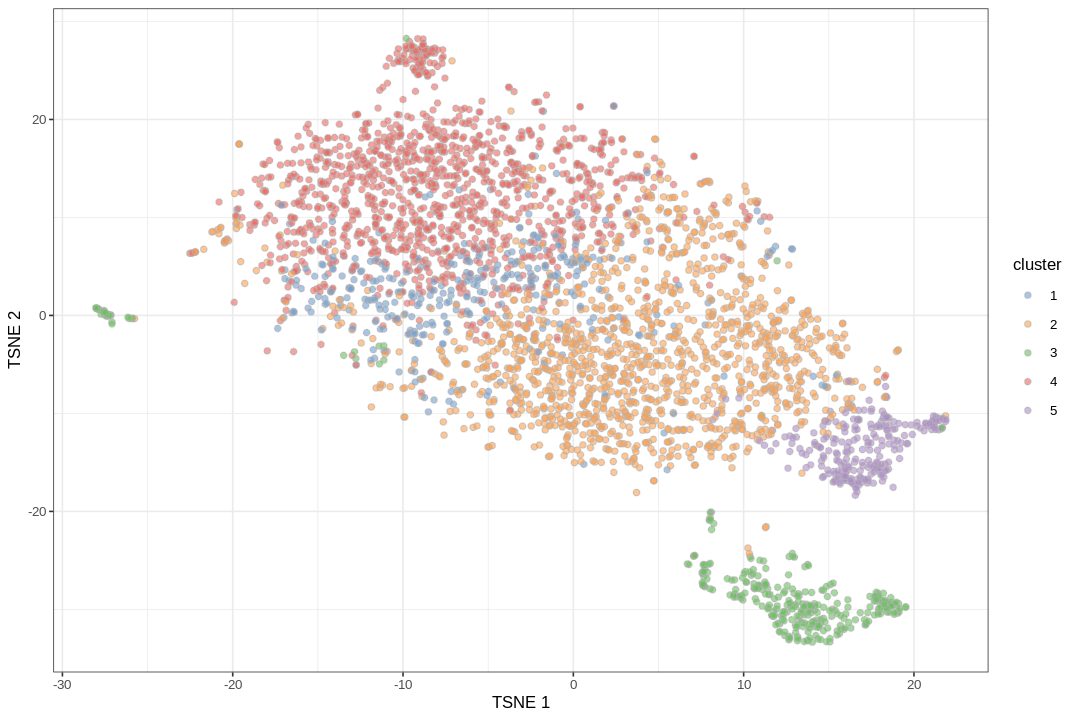

In [29]:
options(repr.plot.width=9, repr.plot.height=6)
sce <- runTSNE(sce, dimred = "PCA", n_dimred = 15)
plotTSNE(sce, colour_by = "cluster")

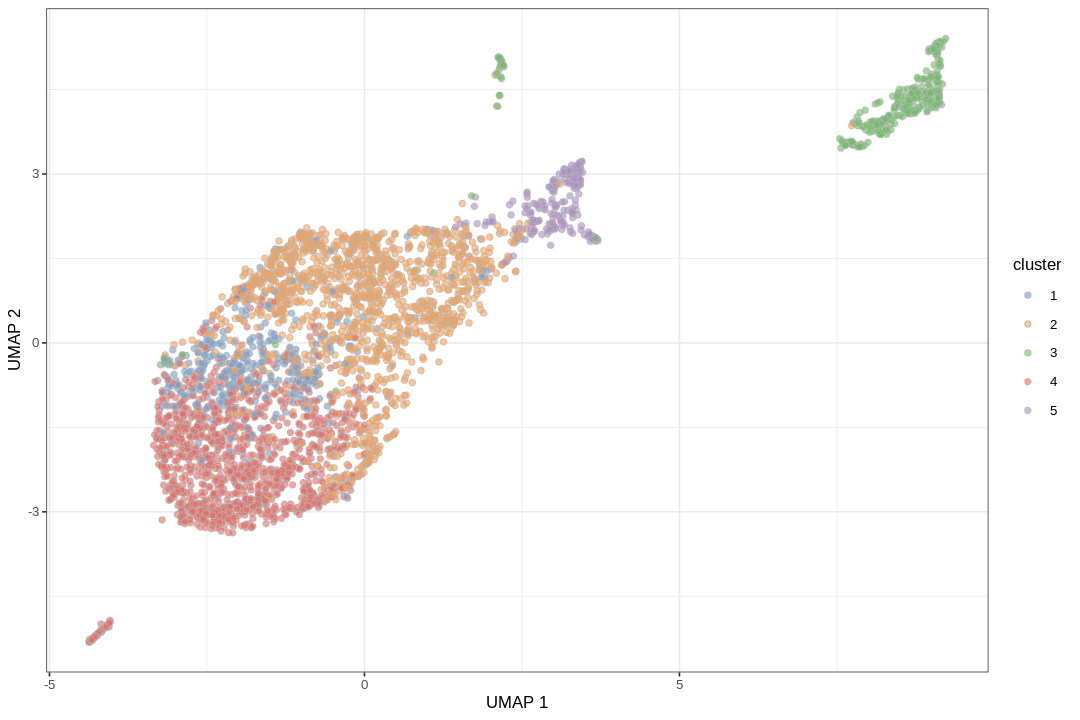

In [30]:
set.seed(1)
sce <- runUMAP(sce, dimred = "PCA", n_neighbors = 30, n_dimred = 15)
plotUMAP(sce, colour_by = "cluster")

In [31]:
Sys.time() - start_time

Time difference of 32.28238 mins

Installing packages took about 22 minutes (the dark side of Rcpp, but in practice, we usually only install packages once for the entire project, or have the same packages shared across projects, not installing packages anew for each notebook, so I don't think this is really terrible news), so all this analysis took only about 10 minutes, from downloading fastqs to clustering and UMAP.